In [356]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Transforming and Splitting Data

In [357]:
df = pd.read_csv("data/combined_expression.csv")

In [358]:
df.head()

,CELL_LINE_NAME,classification,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,COL15A1,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1
0,1240121,1,6.419526,3.182094,9.320548,3.759654,3.802619,3.215753,4.698729,7.873672,...,3.245454,2.953508,3.543429,3.352022,4.672310,3.641128,3.135310,3.737072,3.450927,3.168800
1,1240122,2,7.646494,2.626819,10.153853,3.564755,3.942749,3.290760,3.551675,8.252413,...,2.786709,3.077382,3.728232,3.208882,4.586840,3.395654,3.586800,3.519128,3.115323,3.051645
2,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.459089,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022
3,1240124,1,9.006994,3.028173,9.686700,4.280504,3.147646,3.188881,3.293807,8.678790,...,2.835403,2.960303,3.415083,3.290171,4.770123,3.400821,3.383734,3.798107,2.822404,3.297547
4,1240127,1,7.985676,2.694729,10.676134,4.159685,3.804637,3.481942,3.111261,7.555407,...,2.896523,2.849899,3.480114,3.226128,5.832710,3.612179,3.347095,4.457963,5.198524,4.553586


In [359]:
X = df.drop(columns=['CELL_LINE_NAME', 'classification'])
y = df['classification']
feat_labels = list(X.columns)

In [360]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)

In [361]:
# 20% test, 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Classifier With All Features

In [362]:
# create and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [363]:
# associating each feature with its relative importance
feat_importances = list(zip(feat_labels, clf.feature_importances_))
feat_importances.sort(key = lambda x: x[1], reverse=True)

In [366]:
# plotting the feature importances
import matplotlib.pyplot as plt
plt.tight_layout()

indices = np.arange(len(feat_importances))
x, y = zip(*feat_importances)
y = [i for i in y if i > 0]

<Figure size 720x720 with 0 Axes>

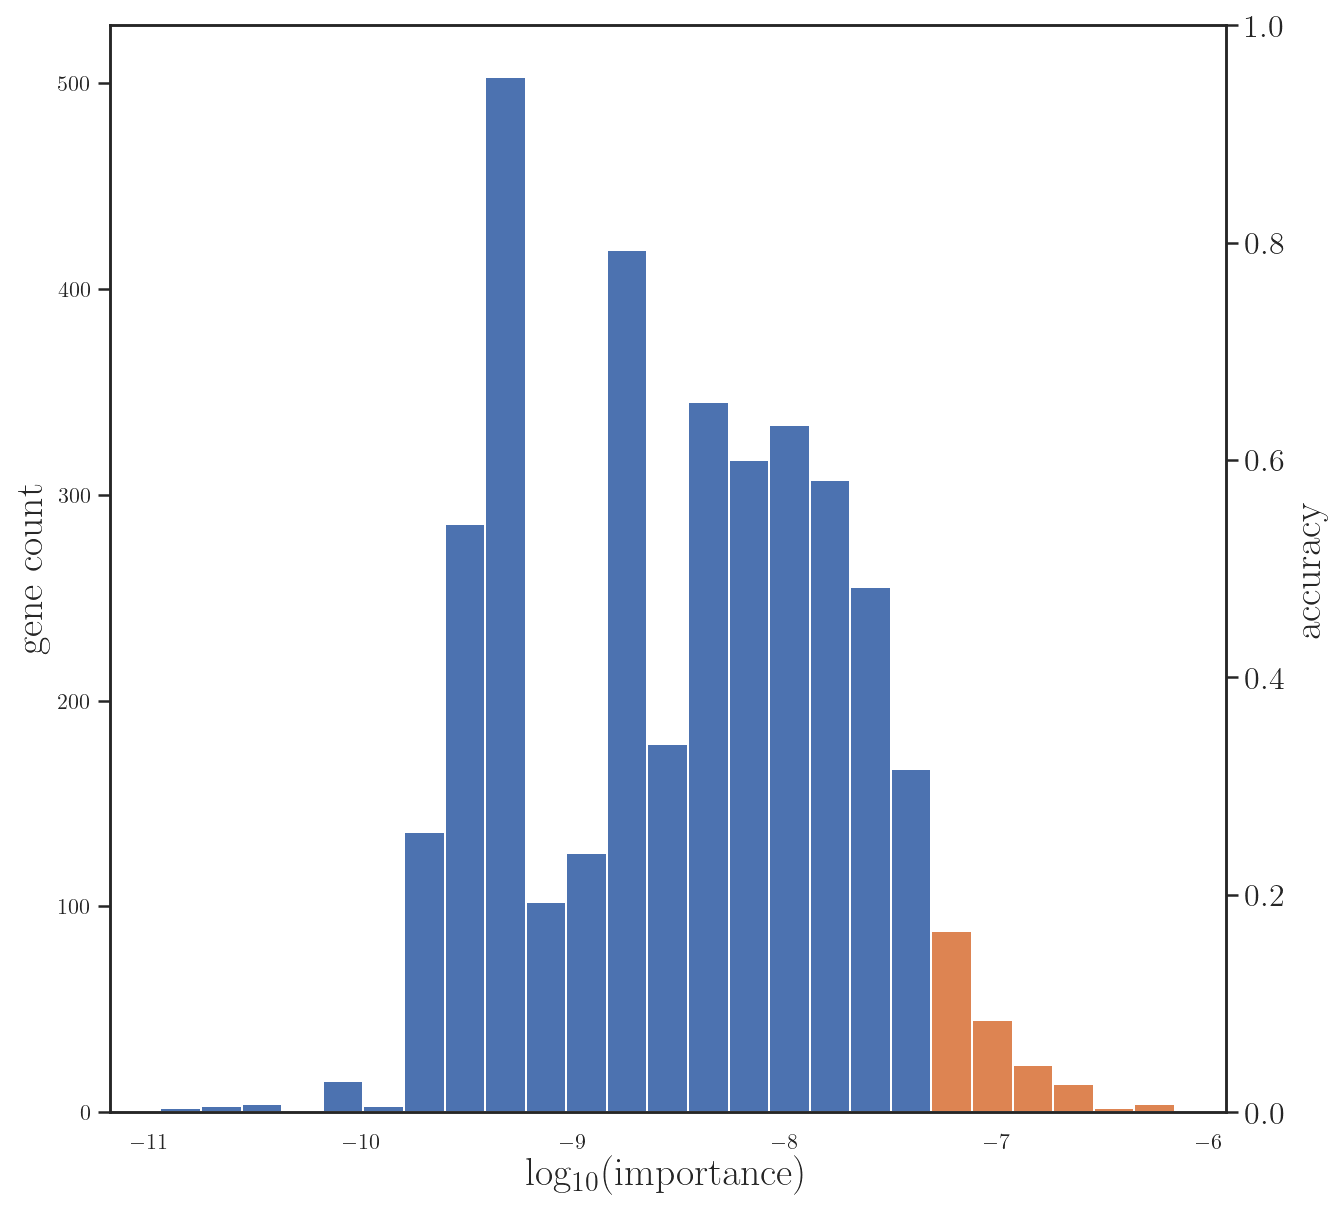

In [387]:
ax1 = plt.subplot(111)
_, _, bars = plt.hist(np.log(y), bins=25, color='C0')

for bar in bars:
    if bar.get_x() >= -7.5:
        bar.set_facecolor('C1')
ax2 = ax1.twinx()
ax1.plot()
ax1.set_xlabel('$\mathrm{log_{10}(importance)}$', size=20)
ax1.set_ylabel('$\mathrm{gene\ count}$', size=20)
ax2.set_ylabel('$\mathrm{accuracy}$', size=20)
plt.tick_params(labelsize=16)

# Testing Various Thresholds
## Defining Functions for Multiple Iterations

In [345]:
def sfm_transforms(sfm, X_train, X_test):
    X_important_train = sfm.transform(X_train)
    X_important_test = sfm.transform(X_test)
    return X_important_train, X_important_test

In [346]:
def det_accuracy(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Testing Multiple Iterations

In [381]:
thresholds = np.linspace(1e-7, 1e-3, 10)
thresholds

array([1.000e-07, 1.112e-04, 2.223e-04, 3.334e-04, 4.445e-04, 5.556e-04,
       6.667e-04, 7.778e-04, 8.889e-04, 1.000e-03])

In [382]:
thresh_accuracy = list()

j=1
for i in thresholds:
    sfm = SelectFromModel(clf, i)
    sfm.fit(X_train, y_train)
    X_important_train, X_important_test = sfm_transforms(sfm, X_train, X_test)

    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf_important.fit(X_important_train, y_train)

    thresh_accuracy.append((i, det_accuracy(clf, X_test, y_test)))

    print(f'Iteration: {j}; threshold: {i}')
    j += 1

Iteration: 1; threshold: 1e-07
Iteration: 2; threshold: 0.00011119999999999999
Iteration: 3; threshold: 0.00022229999999999998
Iteration: 4; threshold: 0.00033339999999999997
Iteration: 5; threshold: 0.00044449999999999996
Iteration: 6; threshold: 0.0005556
Iteration: 7; threshold: 0.0006666999999999999
Iteration: 8; threshold: 0.0007777999999999998
Iteration: 9; threshold: 0.0008888999999999999
Iteration: 10; threshold: 0.001


In [383]:
thresh_accuracy

[(1e-07, 0.5968992248062015),
 (0.00011119999999999999, 0.5968992248062015),
 (0.00022229999999999998, 0.5968992248062015),
 (0.00033339999999999997, 0.5968992248062015),
 (0.00044449999999999996, 0.5968992248062015),
 (0.0005556, 0.5968992248062015),
 (0.0006666999999999999, 0.5968992248062015),
 (0.0007777999999999998, 0.5968992248062015),
 (0.0008888999999999999, 0.5968992248062015),
 (0.001, 0.5968992248062015)]

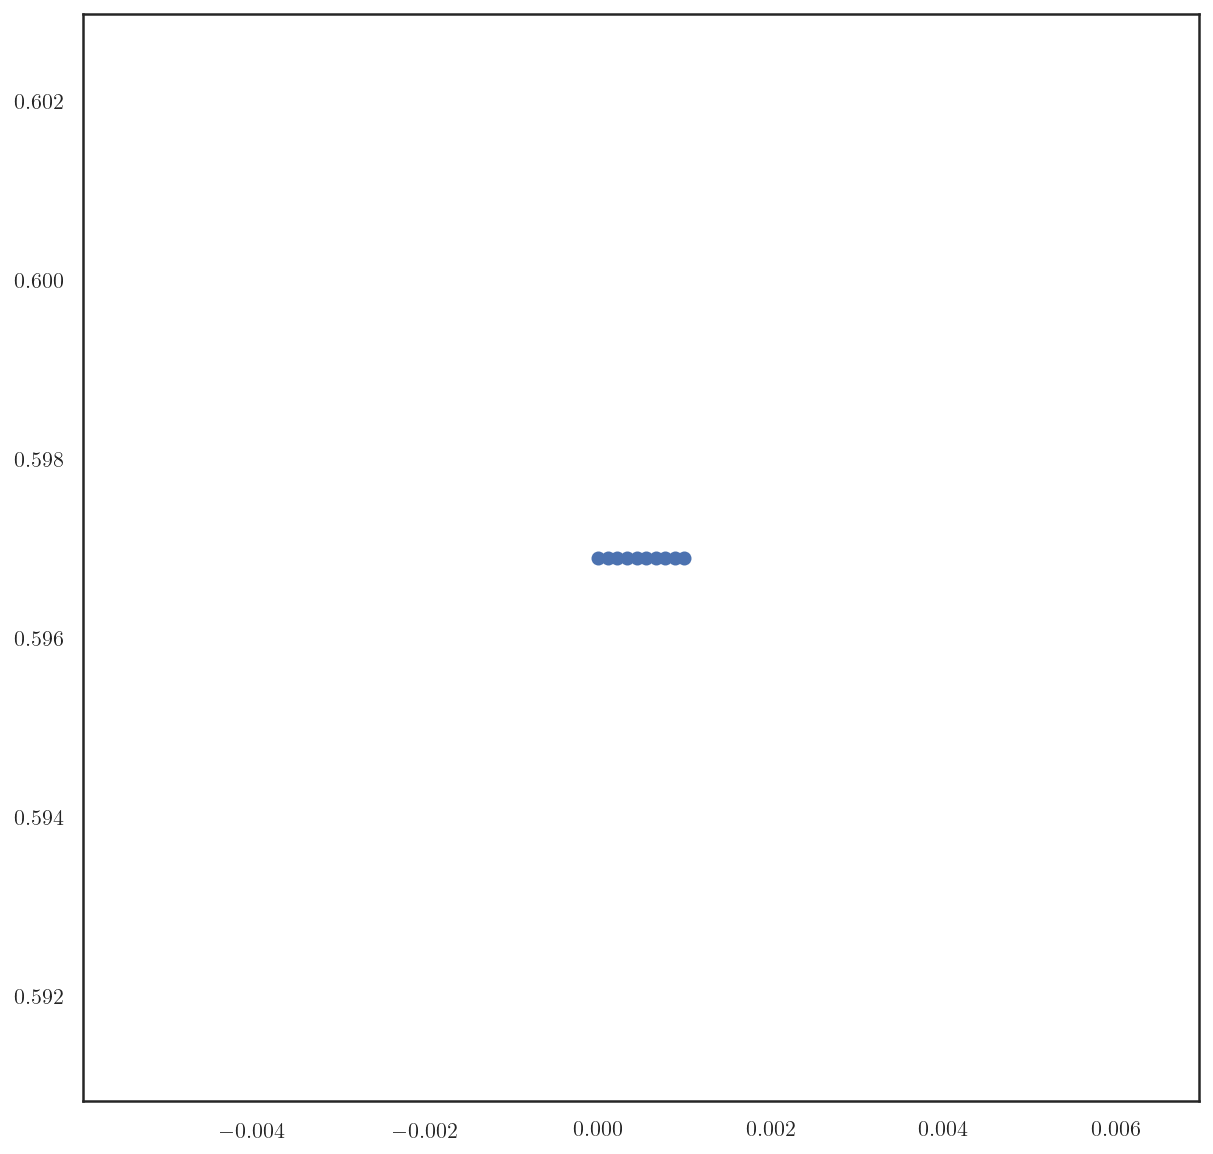

In [384]:
# testList2 = [(np.log(elem1), elem2) for elem1, elem2 in thresh_accuracy]
plt.scatter(*zip(*thresh_accuracy))

In [385]:
len(thresh_accuracy)
thresh_accuracy

[(1e-07, 0.5968992248062015),
 (0.00011119999999999999, 0.5968992248062015),
 (0.00022229999999999998, 0.5968992248062015),
 (0.00033339999999999997, 0.5968992248062015),
 (0.00044449999999999996, 0.5968992248062015),
 (0.0005556, 0.5968992248062015),
 (0.0006666999999999999, 0.5968992248062015),
 (0.0007777999999999998, 0.5968992248062015),
 (0.0008888999999999999, 0.5968992248062015),
 (0.001, 0.5968992248062015)]

# Threshold to Choose
The accuracy does not significantly differ across the thresholds chosen. Therefore, a threshold of 1e-3 of importance will be used as the cutoff as it provides a relatively small subset of the 16833 genes.